# EE954: Assignment 1



                

## Fashion-MNIST Classification using Custom MLP and CNN Models


Authors Email:
- Karan Arora: karanarora23@iitk.ac.in | Contribution: 25%
- Neelesh Batham: neeleshb24@iitk.ac.in | Contribution: 25%
- Advait Patwardhan: advaitmp24@iitk.ac.in | Contribution: 25%
- Tony Varghese: tonyv23@iitk.ac.in | Contribution: 25%


**Code Outline:**

1. Preprocessing:
  - Data Load
  - Transform
  - Split
  - Data Loader


2. MLP Model
- Define Model
- Cross Entropy Loss Define
- Train and Evaluate

3. CNN Model
  - Define model
  - Weights Init
  - Train and Evaluate


6. Evaluate on Test Data
  - prediction
  - metric evaluation ( CE on diffrent HP)



# **Dependencies Installation**

### NOTE: Do not skip this step


In [ ]:
# import the required packages
required_packages = ['torch', 'torchvision', 'matplotlib', 'numpy', 'seaborn']

for package in required_packages:
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} not found. Installing...")
        !pip install {package}
        globals()[package] = __import__(package)

torch is already installed.
torchvision is already installed.
matplotlib is already installed.
numpy is already installed.
seaborn is already installed.


## Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import seaborn as sns


#### PREPROCESSING ####

#1. preprocess the Fashion-MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors and scales pixel values between 0 and 1
    transforms.Lambda(lambda x: x.view(-1))  # flattens the images into 1D vectors
])

train_dataset_full = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)

## Split the training dataset into training and validation sets 80% train and 20% validation.

train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

## Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:01<00:00, 15.9MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 269kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.98MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.40MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## MLP Model

In [2]:
#2 #### MODEL for Classfication #####

# forward pass from scratch

class LinearLayer:
    def __init__(self, input_dim, output_dim):
        self.weight = torch.randn(input_dim, output_dim) * 0.01
        self.bias = torch.zeros(output_dim)

        # ensure parameters do not require gradients
        self.weight.requires_grad = False
        self.bias.requires_grad = False

        # gradients
        self.d_weight = torch.zeros_like(self.weight)
        self.d_bias = torch.zeros_like(self.bias)

    def forward(self, x):
        self.x = x  # save input for backward pass
        return x @ self.weight + self.bias

    def backward(self, grad_output):
        # gradient as per weights and biases
        self.d_weight = self.x.t() @ grad_output
        self.d_bias = grad_output.sum(0)
        # gradient as per inputs
        grad_input = grad_output @ self.weight.t()
        return grad_input

class ReLU:

    def forward(self, x):
        self.x = x
        return torch.clamp(x, min=0)

    def backward(self, grad_output):
        grad_input = grad_output.clone()
        grad_input[self.x <= 0] = 0
        return grad_input

# module for cross-entropy loss

def cross_entropy_loss(logits, labels):
    max_logits = torch.max(logits, dim=1, keepdim=True)[0]
    logits = logits - max_logits  # For numerical stability
    # Softmax value
    exp_logits = torch.exp(logits)
    sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
    softmax = exp_logits / sum_exp_logits
    # Loss calculation
    batch_size = logits.shape[0]
    log_probs = -torch.log(softmax[range(batch_size), labels])
    loss = torch.sum(log_probs) / batch_size
    # gradient  as per logits
    num_classes = logits.size(1)
    # creating new tensor
    one_hot_labels = torch.zeros(batch_size, num_classes, device=logits.device)
    one_hot_labels.scatter_(1, labels.unsqueeze(1), 1)
    grad_output = (softmax - one_hot_labels) / batch_size
    return loss, grad_output


class MLP:
    def __init__(self, input_dim, hidden_dims, output_dim):

        self.layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            self.layers.append(LinearLayer(prev_dim, h_dim))
            self.layers.append(ReLU())
            prev_dim = h_dim

        self.layers.append(LinearLayer(prev_dim, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x  # logits

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def zero_grad(self):
        for layer in self.layers:
            if isinstance(layer, LinearLayer):
                layer.d_weight.zero_()
                layer.d_bias.zero_()


## Train and Evaluate MLP Model

In [3]:
# 3.Train and evaluate with HP

import time

# experiments with different hyperparameters

input_dim = 28 * 28
hidden_dims = [256, 128]
output_dim = 10  # Number of classes in Fashion-MNIST
model = MLP(input_dim, hidden_dims, output_dim)

# Training  the MLP
num_epochs = 10
learning_rate = 0.01


def evaluate(model, data_loader):
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model.forward(images)
            loss, _ = cross_entropy_loss(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


print("Training MLP Model:")

mlp_start_time = time.time()

train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
epochs= []

for epoch in range(num_epochs):

    # training
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        outputs = model.forward(images)
        loss, grad_output = cross_entropy_loss(outputs, labels)
        model.zero_grad()
        model.backward(grad_output)

        # update weights

        for layer in model.layers:
            if isinstance(layer, LinearLayer):
                layer.weight -= learning_rate * layer.d_weight
                layer.bias -= learning_rate * layer.d_bias

        # accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    val_loss, val_accuracy = evaluate(model, val_loader)

    train_accuracies.append(accuracy)
    train_losses.append(avg_loss)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    epochs.append(epoch+1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%')

mlp_end_time = time.time()
mlp_training_time = mlp_end_time - mlp_start_time  # Total training time
print(f"\nTotal Training Time for MLP Model: {mlp_training_time:.2f} seconds")


Training MLP Model:
Epoch [1/10], Loss: 2.2987, Accuracy: 19.07%, Val Loss: 2.2883, Val Accuracy: 16.45%
Epoch [2/10], Loss: 1.9875, Accuracy: 26.14%, Val Loss: 1.4237, Val Accuracy: 44.73%
Epoch [3/10], Loss: 1.1878, Accuracy: 53.06%, Val Loss: 1.0118, Val Accuracy: 59.87%
Epoch [4/10], Loss: 0.9250, Accuracy: 64.57%, Val Loss: 0.8471, Val Accuracy: 67.92%
Epoch [5/10], Loss: 0.8345, Accuracy: 68.65%, Val Loss: 0.7904, Val Accuracy: 71.00%
Epoch [6/10], Loss: 0.7728, Accuracy: 71.69%, Val Loss: 0.7423, Val Accuracy: 73.53%
Epoch [7/10], Loss: 0.7093, Accuracy: 74.05%, Val Loss: 0.6545, Val Accuracy: 76.80%
Epoch [8/10], Loss: 0.6538, Accuracy: 76.47%, Val Loss: 0.6110, Val Accuracy: 78.14%
Epoch [9/10], Loss: 0.6160, Accuracy: 77.93%, Val Loss: 0.5861, Val Accuracy: 79.54%
Epoch [10/10], Loss: 0.5919, Accuracy: 78.96%, Val Loss: 0.5736, Val Accuracy: 79.60%

Total Training Time for MLP Model: 81.50 seconds


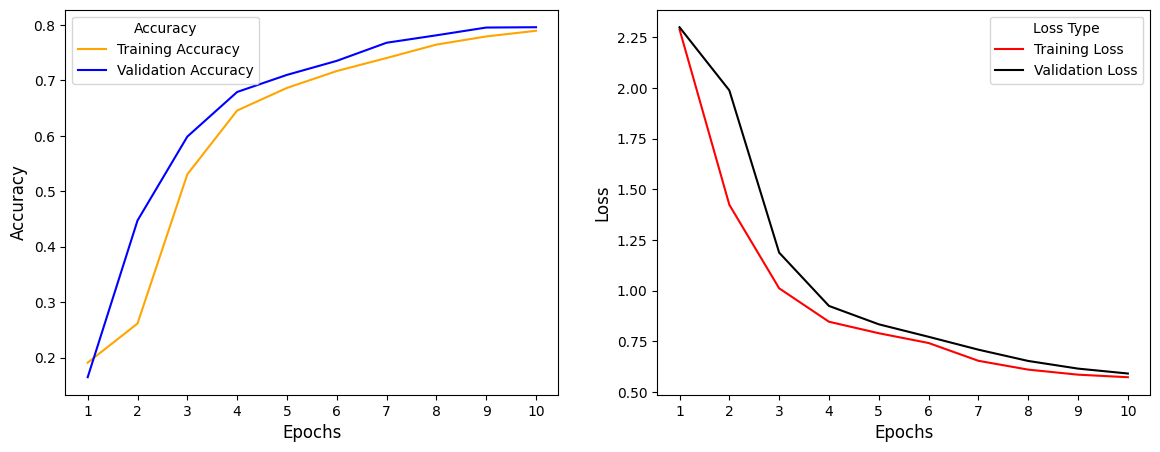

In [4]:
# Plots for MLP accuracy and Loss

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=train_accuracies, color='orange', label='Training Accuracy')
sns.lineplot(x=epochs, y=val_accuracies, color='blue', label='Validation Accuracy')
plt.legend(title="Accuracy")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(epochs)

plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=val_losses, color='red', label="Training Loss")
sns.lineplot(x=epochs, y=train_losses, color='black', label="Validation Loss")
plt.legend(title="Loss Type")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.show()

## **Evaluate on Test DataSet**

In [5]:
def evaluate_mlp_test_dataset(model, data_loader):
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model.forward(images)
            loss, _ = cross_entropy_loss(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

test_loss, test_accuracy = evaluate_mlp_test_dataset(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

Test Loss: 0.6024, Test Accuracy: 78.53%


# **CNN Model**

In [6]:
# Step 3: Implement a CNN backbone model using PyTorch

#  CNN model 5 convolution layers
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input channels = 1 (grayscale), output channels = 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                 # Output: (32,14, 14)
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output channels =64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                 # Output: (64, 7,7)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Output channels= 128
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),# Output channels= 256
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),# Output channels= 512
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)                  # Output: (512, 3, 3)
        )
        # compute the flattened size after convolutional layers
        with torch.no_grad():
            x = torch.randn(1, 1, 28, 28)
            x = self.features(x)
            self._to_linear = x.view(1, -1).size(1)

        # initialize  MLP classifier
        self.classifier = MLP(self._to_linear, [256], 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier.forward(x)
        return x


# TODO: Experiment with different kernel sizes and number of kernels


# different weight initialization methods.
def initialize_weights(model, init_type='he'):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if init_type == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif init_type == 'he':
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            elif init_type == 'random':
                nn.init.uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

cnn_model = CNN()
initialize_weights(cnn_model, init_type='he')

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_transform = transforms.Compose([
    transforms.ToTensor(),  # images as 2D tensors
])

# Reload datasets with the new transform
train_dataset_full_cnn = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=cnn_transform
)

test_dataset_cnn = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=cnn_transform
)

train_dataset_cnn, val_dataset_cnn = random_split(train_dataset_full_cnn, [train_size, val_size])

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)


# training CNN model
def evaluate_cnn(model, data_loader):
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss, _ = cross_entropy_loss(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


print("\nTraining CNN Model:")

cnn_start_time = time.time()

num_epochs = 10
learning_rate = 0.01
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
epochs= []

for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader_cnn:
        # zero the gradients for CNN parameters

        optimizer.zero_grad()

        # forward pass through CNN & MLP
        outputs = cnn_model(images)

        # calculate loss and gradient as pe output
        loss, grad_output = cross_entropy_loss(outputs, labels)

        cnn_model.classifier.zero_grad()
        cnn_model.classifier.backward(grad_output)

        loss.backward()

        optimizer.step()

        with torch.no_grad():
            for layer in cnn_model.classifier.layers:
                if isinstance(layer, LinearLayer):
                    layer.weight -= learning_rate * layer.d_weight
                    layer.bias -= learning_rate * layer.d_bias

        # Compute accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_cnn)
    accuracy = correct / total
    val_loss, val_accuracy = evaluate_cnn(cnn_model, val_loader_cnn)

    train_accuracies.append(accuracy)
    train_losses.append(avg_loss)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    epochs.append(epoch+1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, '
          f'Accuracy: {accuracy*100:.2f}%, Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy*100:.2f}%')
    epoch_time = time.time()
    print(f"Epoch Time: {epoch_time-cnn_start_time}")

cnn_model_end_time = time.time()
cnn_training_time = cnn_model_end_time - cnn_start_time  # Total training time
print(f"\nTotal Training Time for CNN Model: {cnn_training_time:.2f} seconds")


Training CNN Model:
Epoch [1/10], Loss: 0.4746, Accuracy: 82.70%, Val Loss: 0.3119, Val Accuracy: 88.29%
Epoch Time: 67.49712920188904
Epoch [2/10], Loss: 0.2774, Accuracy: 89.78%, Val Loss: 0.2709, Val Accuracy: 90.13%
Epoch Time: 136.48802089691162
Epoch [3/10], Loss: 0.2294, Accuracy: 91.60%, Val Loss: 0.2716, Val Accuracy: 90.23%
Epoch Time: 205.83112835884094
Epoch [4/10], Loss: 0.1961, Accuracy: 92.73%, Val Loss: 0.2334, Val Accuracy: 92.02%
Epoch Time: 274.94171047210693
Epoch [5/10], Loss: 0.1687, Accuracy: 93.68%, Val Loss: 0.2344, Val Accuracy: 92.22%
Epoch Time: 343.28707098960876
Epoch [6/10], Loss: 0.1426, Accuracy: 94.75%, Val Loss: 0.2269, Val Accuracy: 92.44%
Epoch Time: 412.2936005592346
Epoch [7/10], Loss: 0.1183, Accuracy: 95.52%, Val Loss: 0.2561, Val Accuracy: 91.83%
Epoch Time: 481.2934591770172
Epoch [8/10], Loss: 0.1005, Accuracy: 96.22%, Val Loss: 0.2374, Val Accuracy: 92.52%
Epoch Time: 550.4521598815918
Epoch [9/10], Loss: 0.0808, Accuracy: 97.01%, Val Loss:

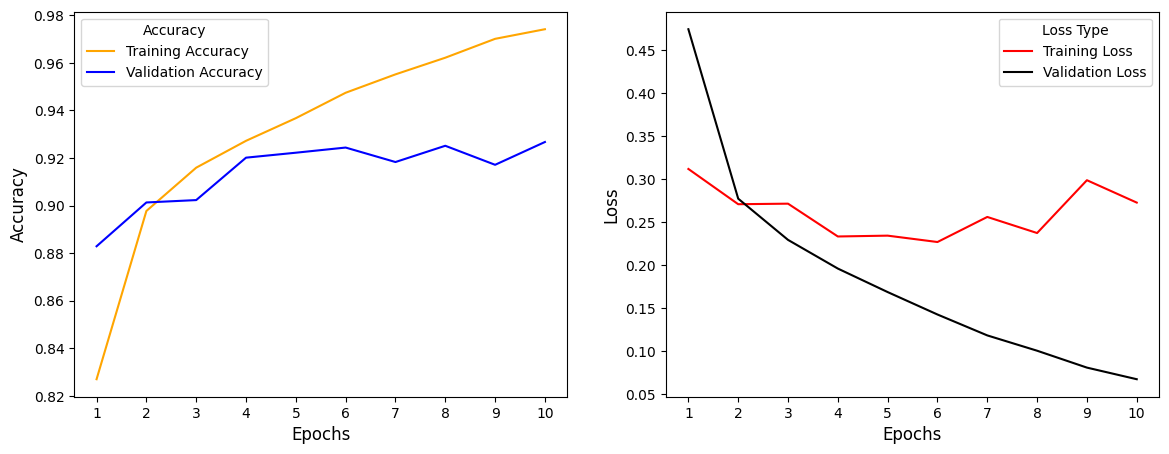

In [7]:
# Plots for CNN accuracy and Loss

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=train_accuracies, color='orange', label='Training Accuracy')
sns.lineplot(x=epochs, y=val_accuracies, color='blue', label='Validation Accuracy')
plt.legend(title="Accuracy")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(epochs)

plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=val_losses, color='red', label="Training Loss")
sns.lineplot(x=epochs, y=train_losses, color='black', label="Validation Loss")
plt.legend(title="Loss Type")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.show()

### **Evaluate CNN Test Dataset**

In [8]:
def evaluate_cnn_test_dataset(model, data_loader):
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss, _ = cross_entropy_loss(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

test_loss, test_accuracy = evaluate_cnn_test_dataset(cnn_model, test_loader_cnn)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

Test Loss: 0.3002, Test Accuracy: 91.81%
